# Example: Virtual circuit calculations

---

This example notebook will demonstrate how to construct **virtual circuits** (VCs) for a **MAST-U-like tokamak** equilibrium.

### What are Virtual Circuits and why are they useful?

VCs can be used to identify which (active) poloidal field (PF) coils have the most significant impact on a set of specified plasma shape parameters (which we will refer to henceforth as **targets**). The targets are equilibrium-related quantities such as the inner or outer midplane radii $R_{in}$ or $R_{out}$ (more will be listed later on). 

More formally, the **virtual circuit** (VC) matrix $V$ for a given equilibrium (and chosen set of shape targets and PF coils) is defined as

$$ V = (S^T S)^{-1} S^T, $$

where $S$ is the **shape** (Jacobian) matrix:

$$ S_{i,j} = \frac{\partial T_i}{\partial I_j}. $$

Here, $T_i$ is the $i$ th target and $I_j$ is the current in the $j$ th PF coil. We note that $V$ is simply the Moore-Penrose pseudo-inverse of $S$. In FreeGSNKE, $S$ will be calculated using finite difference (see below). 

### How can these VCs be used?

Once we know the VC matrix $V$ for a given equilibrium (and its associated target values $\vec{T}$), we can specify a perturbation in the targets $\vec{\Delta T}$ and calculate the change in coil currents required to acheive the new targets. The shifts in coil currents can be found via:

$$ \vec{\Delta I} = V \vec{\Delta T}. $$

Using $\vec{\Delta I}$ we can perturb the coil currents in our equilibrium, re-solve the static forward Grad-Shafranov (GS) problem, and observe how the targets (call them $\vec{T}_{new}$) have changed 
in the new equilibrium vs. the old targets $\vec{T}$.

 ---


### Generate a starting equilibrums

Firstly, we need an equilbirium to test the VCs on.

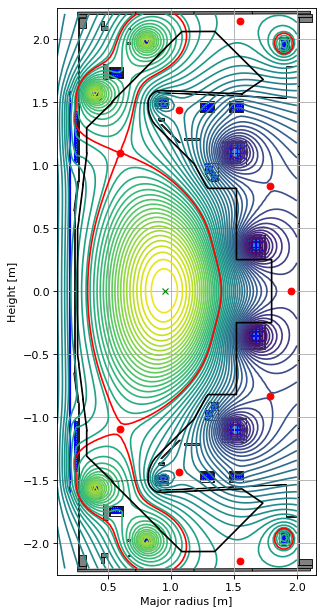

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"
os.environ["PROBE_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_magnetic_probes.pickle" 

# build the machine
from freegsnke import build_machine
tokamak = build_machine.tokamak()

# initialise the equilibrium
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

# load the nonlinear solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set the coil currents
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out the foward solve to find the equilibrium
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-4)

# updates the plasma_psi (for later on)
eq._updatePlasmaPsi(eq.plasma_psi)

# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

### Initialise the VC class

We initialise the VC class and tell it to use the static solver we already initialised above. This will be used to repeatedly (and rapidly) to solve the static GS problem when calculating the finite differences for the shape matrix.

In [2]:
from freegsnke import virtual_circuits

VCs = virtual_circuits.VirtualCircuitHandling()
VCs.define_solver(GSStaticSolver)

### Define shape targets

Next we need to define the shape targets (i.e. our quantities of interest) that we wish to monitor. There are a number of shape target pre-defined in FreeGSNKE:
- "R_in": inner midplane radius.  
- "R_out": outer midplane radius.  
- "Rx_lower": lower X-point (radial) position.
- "Zx_lower": lower X-point (vertical) position.
- "Rx_upper": upper X-point (radial) position.
- "Zx_upper": upper X-point (vertical) position.
- "Rs_lower_outer": lower strikepoint (radial) position.
- "Rs_upper_outer": upper strikepoint (radial) position.

Note that the following targets require additional options:
- "Rx_lower": approx. radial position of the lower X-point (R,Z).
- "Zx_lower": approx. vertical position of the lower X-point (R,Z).
- "Rx_upper": approx. radial position of the upper X-point (R,Z).
- "Zx_upper": approx. vertical position of the upper X-point (R,Z).
- "Rs_lower_outer": approx. (R,Z) position of the lower outer strikepoint.
- "Rs_upper_outer": approx. (R,Z) position of the upper outer strikepoint.
            
We'll see how these options are defined in a moment. While they are not all strictly required, having them is advisable as the default calculations may return spurious values in some rare cases. 

More can be added (via a feature request), though we should say that it would need to be generic enough such that its definition is well-defined across different tokamak geometries and plasmas.

There is the option to specify **custom** shape targets if these do not work for you---we will see this shortly.

In [3]:
# define the targets of interest and use the VC object to calculate their values for the equilibrium above
targets = ['R_in', 'R_out', 'Rx_lower', 'Zx_lower', 'Rx_upper', 'Zx_upper', 'Rs_lower_outer', 'Rs_upper_outer']

# define the target options in a dictionary (approx. (R,Z) locations of the X-points)
# this helps identify the correct X-point in the code
targets_options = dict()
targets_options['Rx_lower'] = np.array([0.6, -1.1])
targets_options['Zx_lower'] = np.array([0.6, -1.1])
targets_options['Rx_upper'] = np.array([0.6, 1.1])
targets_options['Zx_upper'] = np.array([0.6, 1.1])
targets_options['Rs_lower_outer'] = np.array([1.15, -2.1])
targets_options['Rs_upper_outer'] = np.array([1.15, 2.1])


_, target_values = VCs.calculate_targets(eq, targets, targets_options)

# print
for i in range(len(targets)):
    print(targets[i] + " = " + str(target_values[i]))


R_in = 0.34077663831638644
R_out = 1.401436887062773
Rx_lower = 0.5963658696853431
Zx_lower = -1.0945059861551971
Rx_upper = 0.5960740308006363
Zx_upper = 1.0987766268377714
Rs_lower_outer = 1.120123536896205
Rs_upper_outer = 1.1221796132746775


/Users/kpentlan/Documents/Projects/Software/freegs4e/freegs4e/critical.py:830: UserWarning: Theta grid too close to X-point, shifting by half-step
  warn("Theta grid too close to X-point, shifting by half-step")


We can also define **custom** shape targets by following the template in the next cell.

For example, here we show how to calculate the $R_{gap}$ distance in the lower divertor. This is defined (in MAST-U at least) as the radial position of the point on the separatrix at $Z=-1.5$ and the wall (on the right side). 

In [4]:
# any new target function should take the equilibrium object as input
import shapely as sh # requires the shapely package

def R_gap_lower(eq):
    
    # find contour object for psi_boundary
    if eq._profiles.flag_limiter:
        cs = plt.contour(
            eq.R, eq.Z, eq.psi(), levels=[eq._profiles.psi_bndry]
        )
    else:
        cs = plt.contour(
            eq.R, eq.Z, eq.psi(), levels=[eq._profiles.xpt[0][2]]
        )
    plt.close()  # this isn't the most elegant but we don't need the plot iteq

    # for each item in the contour object there's a list of points in (r,z) (i.e. a line)
    psi_boundary_lines = []
    for i, item in enumerate(cs.allsegs[0]):
        psi_boundary_lines.append(item)

    # use the shapely package to find where each psi_boundary_line intersects the z line
    gaps = []
    z_line = np.array([[0.5,-1.5],[0.8,-1.5]])
    curve1 = sh.LineString(z_line)
    for j, line in enumerate(psi_boundary_lines):
        curve2 = sh.LineString(line)

        # find the intersection point(s)
        intersection = curve2.intersection(curve1)

        # extract intersection point(s)
        if intersection.geom_type == "Point":
            gaps.append(np.squeeze(np.array(intersection.xy).T))
        elif intersection.geom_type == "MultiPoint":
            gaps.append(
                np.squeeze(
                    np.array([geom.xy for geom in intersection.geoms])
                )
            )

    gap_point = np.array(gaps).squeeze()

    return gap_point[0] # select R position

# we then create a list of lists to store the target name and its function, e.g. [["new_target_name", ...], [new_target_function(eq),...]]
non_standard_targets = [["R_gap_lower"], [R_gap_lower]]


In [5]:
# we can now include our custom target functions
all_target_names, all_target_values = VCs.calculate_targets(eq, targets, targets_options, non_standard_targets)

# print
for i in range(len(all_target_names)):
    print(all_target_names[i] + " = " + str(all_target_values[i]))


R_in = 0.34077663831638644
R_out = 1.401436887062773
Rx_lower = 0.5963658696853431
Zx_lower = -1.0945059861551971
Rx_upper = 0.5960740308006363
Zx_upper = 1.0987766268377714
Rs_lower_outer = 1.120123536896205
Rs_upper_outer = 1.1221796132746775
R_gap_lower = 0.7144953790108666


Let us visualise the targets on our equilibrium. 

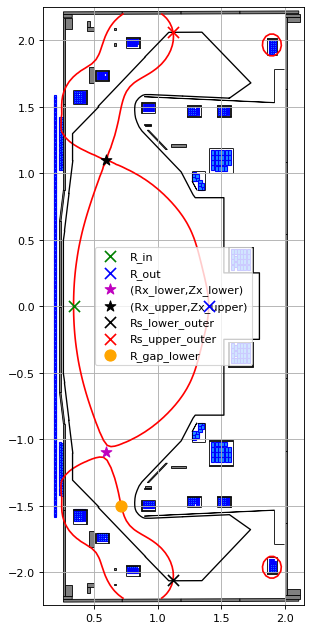

In [6]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')
eq.tokamak.plot(axis=ax1, show=False)
ax1.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.scatter(all_target_values[0], 0.0, s=100, color='green', marker='x', zorder=20, label=all_target_names[0])
ax1.scatter(all_target_values[1], 0.0, s=100, color='blue', marker='x', zorder=20, label=all_target_names[1])
ax1.scatter(all_target_values[2], all_target_values[3], s=100, color='m', marker='*', zorder=20, label=f"({all_target_names[2]},{all_target_names[3]})")
ax1.scatter(all_target_values[4], all_target_values[5], s=100, color='k', marker='*', zorder=20, label=f"({all_target_names[4]},{all_target_names[5]})")
ax1.scatter(all_target_values[6], -2.06 , s=100, color='k', marker='x', zorder=20, label=f"{all_target_names[6]}")
ax1.scatter(all_target_values[7], 2.06 , s=100, color='r', marker='x', zorder=20, label=f"{all_target_names[7]}")
ax1.scatter(all_target_values[8], -1.5 , s=100, color='orange', marker='o', zorder=5, label=f"{all_target_names[8]}")

ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.legend(loc="center")
plt.tight_layout()

### Calculating the VCs

Now we've defined the targets we're interested in, we can begin calculating the **shape** and **virtual circuit** matrices. The following is a brief outline of how they're calculated:

##### 1. Initialise and solve the base equilibrium
Before computing derivatives, the static forward GS solver is run with some initial coil currents. Following this we store the:
- equilibrium state `eq` and plasma profiles `profiles`.
- plasma current vector $I_y$ (which defines the amount of plasma current at each computational grid point, restricted to the limiter region to save computational resources).
- target values $\vec{T} = [T_1,\ldots,T_{N_T}]$ are evaluated.

This establishes a reference state before we perturb the coil currents - we have already carried out these steps above (the $I_y$ vector is stored within `profiles`).

##### 2. Find the appropriate coil current perturbations
Next, we need to identify the appropriate coil current perturbations $\vec{\delta I}$ to use in the finite differences. To do this, we aim to scale the starting guess `starting_dI` (denoted $\vec{\delta I}^{start}$) according to the target tolerance on the plasma current vector (`target_dIy` = $\delta I_y^{target}$). While the user can choose `starting_dI`, the default is given by

$$ \vec{\delta I}^{start} := | \vec{I} | \times \delta I_y^{target}.  $$

For each coil current $j \in \{1,\ldots,N_c \}$, this starting guess is scaled as follows:
1. Perturb coil current $j$: 

$$ I_j^{new} := I_j + \delta I_j^{start}.$$

2. Solve the equilibrium with the updated $j$ th coil current (others are left unchanged) and store the plasma current vector $\vec{I}_y^{new}$.

3. The starting guess for the $j$ th coil current perturbation is then scaled by the relative norm of the plasma current change (and the predefined target tolerance `target_dIy`):

$$ \delta I_j^{final} = \delta I_j^{start} \times \left( \delta I_y^{target} \frac{\| \vec{I}_y^{start} \|}{\| \vec{I}_y^{new} - \vec{I}_y^{start} \|} \right).$$

If this relative norm is larger than $\delta I_y^{target}$, then the starting guess $\delta I_j^{start}$ needs to be made smaller (and vice versa). 

After this, we have our scaled perturbations $\vec{\delta I}^{final}$ ready to use in the finite differences. 

##### 3. Find the finite differences (i.e. the shape matrix)
For each coil current $j \in \{1,\ldots,N_c \}$:

1. Perturb coil current $j$: 

$$ I_j^{new} := I_j + \delta I_j^{final}.$$

2. Solve the equilibrium with the updated $j$ th coil current (others are left unchanged) and store the plasma current vector $\vec{I}_y^{new}$.

3. Using the new target values $\vec{T}^{new}$ from the equilibrium, calculate the $j$ th column of the shape matrix:

$$ S_{:,j} = \frac{\vec{T}^{new} - \vec{T}}{\delta I_j^{final}}. $$

This gives the sensitivity of each of the targets $T_i$ with respect to a change in the $j$ th coil current.

Note that we can also obtain the Jacobian matrix of the plasma current vector (using $\vec{I}_y^{new}$) with respect to the coil currents: $\frac{\partial \vec{I}_y}{\partial \vec{I}}$.

##### 4. Find the virtual circuit matrix
Once the full shape matrix $S \in \Reals^{N_T \times N_c} $ is known, the **virtual circuit matrix** is computed as:

$$ V = (S^T S)^{-1} S^T \in \Reals^{N_c \times N_T}.$$

This matrix provides a mapping from requested shifts in the targets to the shifts in the coil currents required.

In [7]:
# define which coils we wish to calculate the shape (finite difference) derivatives (and therefore VCs) for
coils = eq.tokamak.coils_list[0:12]
print(coils)

['Solenoid', 'PX', 'D1', 'D2', 'D3', 'Dp', 'D5', 'D6', 'D7', 'P4', 'P5', 'P6']


In [8]:
# here we'll look at a subset of the coils and the targets
coils = ['D1', 'D2', 'D3', 'Dp', 'D5', 'D6', 'D7', 'P4', 'P5']
targets = ['R_in', 'R_out', 'Rx_lower', 'Zx_lower', 'Rs_lower_outer']
non_standard_targets = [["R_gap_lower"], [R_gap_lower]]

In [9]:
# calculate the shape and VC matrices as follows
VCs.calculate_VC(
    eq=eq,
    profiles=profiles,
    coils=coils,
    targets=targets,
    targets_options=targets_options,
    target_dIy=1e-3,
    non_standard_targets=non_standard_targets,
    starting_dI=None,
    min_starting_dI=50,
    verbose=True,
    VC_name="VC_for_lower_targets", # name for the VC
    )

---
Preparing the scaled current shifts with respect to the:
0th coil (D1) using initial current shift 50.0.
1th coil (D2) using initial current shift 50.0.
2th coil (D3) using initial current shift 50.0.
3th coil (Dp) using initial current shift 50.0.
4th coil (D5) using initial current shift 50.0.
5th coil (D6) using initial current shift 50.0.
6th coil (D7) using initial current shift 50.0.
7th coil (P4) using initial current shift 50.0.
8th coil (P5) using initial current shift 50.0.
---
Building the shape matrix with respect to the:
0th coil (D1) using scaled current shift 19.95000292057369.
1th coil (D2) using scaled current shift 20.338972830815724.
2th coil (D3) using scaled current shift 15.384603635981408.
3th coil (Dp) using scaled current shift 6.467439469434446.
4th coil (D5) using scaled current shift 4.2858985289005895.
5th coil (D6) using scaled current shift 4.424281304579926.
6th coil (D7) using scaled current shift 3.8165089756857014.
7th coil (P4) using scaled curre

In [10]:
# these are the finite difference derivatives of the targets wrt the coil currents
shape_matrix = 1.0*VCs.shape_matrix
print(f"Dimension of the shape matrix is {shape_matrix.shape} [no. of targets x no. of coils]. Has units [m/A]")

# these are the VCs corresponding to the above shape matrix
VCs_matrix = 1.0*VCs.VCs_matrix
print(f"Dimension of the virtual circuit matrix is {VCs_matrix.shape} [no. of coils x no. of targets]. Has units [A/m].")


Dimension of the shape matrix is (6, 9) [no. of targets x no. of coils]. Has units [m/A]
Dimension of the virtual circuit matrix is (9, 6) [no. of coils x no. of targets]. Has units [A/m].


### How do we make use of the VCs?

Now that we have the VCs, we can use them to idenitfy the coil current shifts required to change the targets by a certain amount. 

For example, we will ask for shifts in a few shape targets and observe what happens to the equilibrium once we apply the new currents from the VCs. 

In [11]:
# let's remind ourselves of the targets
print(targets)
for i in range(len(non_standard_targets[0])):
    print(non_standard_targets[0][i])

['R_in', 'R_out', 'Rx_lower', 'Zx_lower', 'Rs_lower_outer']
R_gap_lower


In [12]:
# ask for shifts (units are metres)
targets_shift = [0.01, -0.01, 0.0, 0.0, 0.0]
non_standard_targets_shift = [0.0]

We specify a perturbation in the targets $\vec{\Delta T}$  (the shifts above) and calculate the change in coil currents required to achieve this by calculating:

$$ \vec{\Delta I} = V \vec{\Delta T}. $$

Using $\vec{\Delta I}$ we then perturb the coil currents in our original equilibrium, re-solve the static forward Grad-Shafranov (GS) problem, and return. This is all done in the following cell. 

In [13]:
# we apply the VCs to the desired shifts
eq_new, profiles_new, all_targets, new_target_values, old_target_values = VCs.apply_VC(
    eq=eq,
    profiles=profiles,
    coils=coils,
    targets=targets,
    targets_options=targets_options,
    targets_shift=targets_shift,
    non_standard_targets=non_standard_targets,
    non_standard_targets_shift=non_standard_targets_shift,
    verbose=True,
)

Currents shifts from VCs:
['D1', 'D2', 'D3', 'Dp', 'D5', 'D6', 'D7', 'P4', 'P5'] = [  554.22607744  1498.24707848   442.98763597 -1050.25245771
  -200.95925534  -862.0744483    -80.72971703  1583.99734458
  -392.38540212].
Targets shifts from VCs:
['R_in', 'R_out', 'Rx_lower', 'Zx_lower', 'Rs_lower_outer', 'R_gap_lower'] = [ 1.11081205e-02 -9.14774277e-03  5.74047396e-04 -9.66266772e-04
  1.17621999e-04  6.36852532e-05].


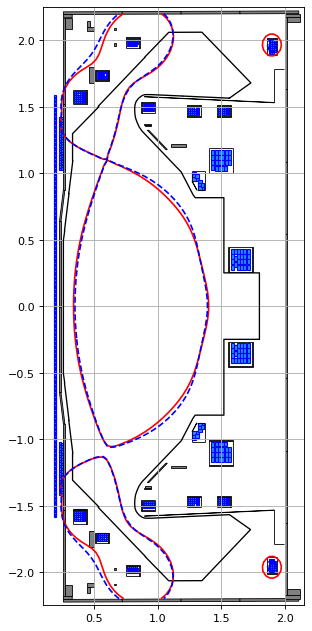

In [14]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
ax1.plot(eq.tokamak.wall.R, eq.tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
eq.tokamak.plot(axis=ax1, show=False)

ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')
ax1.contour(eq.R, eq.Z, eq_new.psi(), levels=[eq_new.psi_bndry], colors='b', linestyles="--")

ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

plt.tight_layout()

We can then measure the accuracy of the VCs by observing the difference between the requested change in shape targets vs. those enacted by the VCs. 
 


In [15]:
for i in range(len(all_targets)):
    print(f"Difference in {all_targets[i]} = {np.round(new_target_values[i] - old_target_values[i],3)} vs. requested = {(targets_shift + non_standard_targets_shift)[i]}.")


Difference in R_in = 0.011 vs. requested = 0.01.
Difference in R_out = -0.009 vs. requested = -0.01.
Difference in Rx_lower = 0.001 vs. requested = 0.0.
Difference in Zx_lower = -0.001 vs. requested = 0.0.
Difference in Rs_lower_outer = 0.0 vs. requested = 0.0.
Difference in R_gap_lower = 0.0 vs. requested = 0.0.


In the plots below, we can see the actual shifts by the VCs are almost exactly as those requested (for the targets with actual shifts). Note how the unshifted targets also shift under the VCs due to the nonlinear coupling between targets and coil currents. 

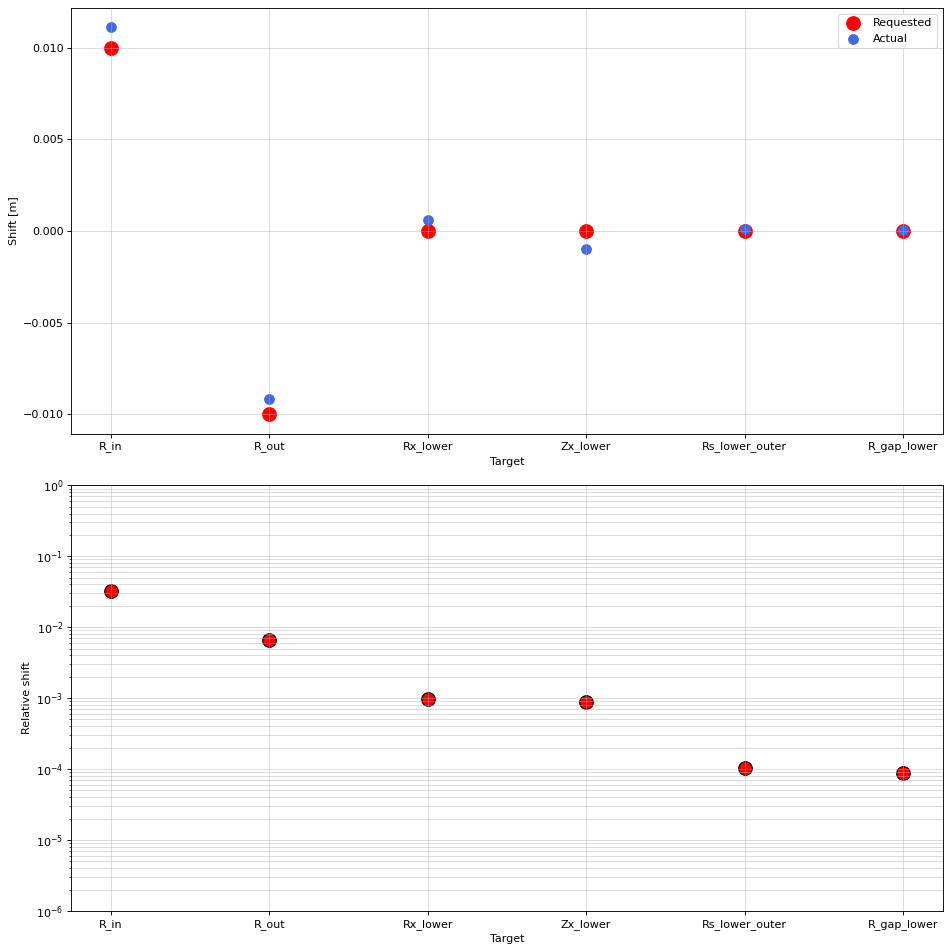

In [16]:
# plots
rel_diff = np.abs(np.array(new_target_values) - np.array(old_target_values))/np.abs(old_target_values)

fig1, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(12,12), dpi=80)

ax1.grid(True, which='both', alpha=0.5)
ax1.scatter(all_targets, targets_shift + non_standard_targets_shift, color='red', marker='o', s=150, label="Requested")
ax1.scatter(all_targets, np.array(new_target_values) - np.array(old_target_values), color='royalblue', marker='o', s=75, label="Actual")
ax1.set_xlabel("Target")
ax1.set_ylabel("Shift [m]")
ax1.legend()
# ax1.set_ylim([-max(targets_shift+non_standard_targets_shift)*1.1, max(targets_shift+non_standard_targets_shift)*1.1])

ax2.grid(True, which='both', alpha=0.5)
ax2.scatter(all_targets, rel_diff, color='red', marker='o', s=150, edgecolors='black', label="Requested")
ax2.set_xlabel("Target")
ax2.set_ylabel("Relative shift")
labels = ax2.get_xticklabels()
ax2.set_yscale('log')
ax2.set_ylim([1e-6, 1e-0])

plt.tight_layout()

### Alternative VCs

Note that when the `VC_calculate` method is called, a `VC_name` can be provided. This will store the key data in a subclass with `VC_name`. This useful for recalling from which targets and coils a given shape matrix or VC matrix was calculated. 

Note that if no `VC_name` is provided the default is used ("latest_VC").

In [17]:
# display the attributes
print(VCs.VC_for_lower_targets.__dict__.keys())

dict_keys(['name', 'eq', 'profiles', 'shape_matrix', 'VCs_matrix', 'targets', 'coils'])


You can then follow up by calculating alternative VCs for different target and coil combinations. 

In [18]:
# choose new coils and targets
coils = ['D1', 'D2', 'D3', 'Dp', 'D5', 'D6', 'D7', 'P4', 'P5']
targets = ['Rx_upper', 'Zx_upper', 'Rs_upper_outer'] # this time we use the upper targets
targets_options = dict()
targets_options['Rx_upper'] = np.array([0.6, 1.1])
targets_options['Zx_upper'] = np.array([0.6, 1.1])
targets_options['Rs_upper_outer'] = np.array([1.15, 2.1])


# calculate the shape and VC matrices
VCs.calculate_VC(
    eq=eq,
    profiles=profiles,
    coils=coils,
    targets=targets,
    targets_options=targets_options,
    target_dIy=1e-3,
    non_standard_targets=None,
    starting_dI=None,
    min_starting_dI=50,
    verbose=True,
    VC_name="VC_for_upper_targets",
    )

---
Preparing the scaled current shifts with respect to the:
0th coil (D1) using initial current shift 50.0.
1th coil (D2) using initial current shift 50.0.
2th coil (D3) using initial current shift 50.0.
3th coil (Dp) using initial current shift 50.0.
4th coil (D5) using initial current shift 50.0.
5th coil (D6) using initial current shift 50.0.
6th coil (D7) using initial current shift 50.0.
7th coil (P4) using initial current shift 50.0.
8th coil (P5) using initial current shift 50.0.
---
Building the shape matrix with respect to the:
0th coil (D1) using scaled current shift 19.95000292057369.
1th coil (D2) using scaled current shift 20.338972830815724.
2th coil (D3) using scaled current shift 15.384603635981408.
3th coil (Dp) using scaled current shift 6.467439469434446.
4th coil (D5) using scaled current shift 4.2858985289005895.
5th coil (D6) using scaled current shift 4.424281304579926.
6th coil (D7) using scaled current shift 3.8165089756857014.
7th coil (P4) using scaled curre

In [19]:
# display the attributes
print(VCs.VC_for_upper_targets.__dict__.keys())

dict_keys(['name', 'eq', 'profiles', 'shape_matrix', 'VCs_matrix', 'targets', 'coils'])


In [20]:
VCs.VC_for_upper_targets.VCs_matrix

array([[ 14420.44724942, -10363.37645124,  -1996.55795099],
       [  8291.69319056,  -6382.54870909,   -292.28914918],
       [ -1372.73440565,  -1967.37072661,   4583.43469319],
       [ 16927.02030772, -10848.08199113,  -2229.85980424],
       [ -5737.34527098,   2450.14681841,   5083.11148589],
       [  3170.29239115,  -1273.01151809,    771.09057684],
       [  -679.49215507,   1325.42931727,   1657.3366104 ],
       [  -911.04263295,   4621.42317403,  -1231.96281484],
       [ -3314.38380778,   8431.2496118 ,  -2232.52319152]])